<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/7_TopicosAvanzados/2_Autoencoders/3_Autoencoder_TwoOutputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from typing import Optional, Sequence

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, f1_score
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
#Load and prepare the Fashion MNIST dataset

scale: float = 0.4 #variabilidad del ruido
(x_train, y_train), (x_test, y_test) = mnist.load_data()#cargo la base de datos mnist
x_train = x_train.astype('float32') / 255. + np.random.normal(scale=scale, size=x_train.shape) #normalizo la imagen y agragando ruido
x_test = x_test.astype('float32') / 255. + np.random.normal(scale=scale, size=x_test.shape) #normalizo la imagen y agragando ruido

# create training, validation, and testing sets
x_val = x_train[50000:] #estoy dejando para validar,desde el 50.000 en adelante, es decir, 10.000 datos para validar
y_val = y_train[50000:] #estoy dejando para validar,desde el 50.000 en adelante, es decir, 10.000 datos para validar
x_train = x_train[:50000] #estoy dejando para entrenar los primeros 50.000 datos
x_train = x_train[..., tf.newaxis] #creo una nueva dimensión para los filtros convolucionales.
y_train = y_train[:50000] #estoy dejando para validar,desde el 50.000 en adelante, es decir, 10.000 datos para validar
x_val = x_val[..., tf.newaxis] #creo una nueva dimensión para los filtros convolucionales.
x_val = x_val[..., tf.newaxis] #creo una nueva dimensión para los filtros convolucionales.
x_test = x_test[..., tf.newaxis] #creo una nueva dimensión para los filtros convolucionales.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(x_train.shape,x_val.shape,x_test.shape,y_train.shape,y_val.shape,y_test.shape)

(50000, 28, 28, 1) (10000, 28, 28, 1, 1) (10000, 28, 28, 1) (50000,) (10000,) (10000,)


In [5]:
def plot_mnist_autoencoder(
    x: Sequence[np.ndarray], 
    x_: Sequence[np.ndarray], 
    y: Optional[Sequence] = None, 
    y_: Optional[Sequence] = None, 
    cmap: str = 'gray', 
    vmin: float = 0, 
    vmax: float = 1
) -> None:
    """
    Plot the original and reconstructed MNIST images using an autoencoder.

    Parameters
    ----------
    x : Sequence[np.ndarray]
        Original images.
    x_ : Sequence[np.ndarray]
        Reconstructed images.
    y : Optional[Sequence], optional
        True labels of the images, by default None.
    y_ : Optional[Sequence], optional
        Predicted labels of the images, by default None.
    cmap : str, optional
        Color map for the images, by default 'gray'.
    vmin : float, optional
        Minimum value for normalization, by default 0.
    vmax : float, optional
        Maximum value for normalization, by default 1.

    Examples
    --------
    >>> plot_mnist_autoencoder(original_images, reconstructed_images)
    """
    plt.figure(figsize=(20, 2))
    for i, (train, predict) in enumerate(zip(x, x_), start=1):
        plt.subplot(2, len(x), i)
        plt.imshow(train.reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.axis('off')
        
        plt.subplot(2, len(x), i + len(x))
        plt.imshow(predict.reshape(28, 28), cmap=cmap, vmin=vmin, vmax=vmax)
        plt.axis('off')

        if y is not None and y_ is not None:
            color = "red" if y[i - 1] != y_[i - 1] else 'green'
            plt.text(
                0, 28, str(y_[i - 1]), color=color, fontsize=15, 
                verticalalignment='bottom', horizontalalignment='left'
            )

In [6]:
#plot images on latent space
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(5,5))
    plt.axis('off')
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()
    plt.show()

In [7]:
x_train.shape

(50000, 28, 28, 1)

In [8]:
x_train.reshape(x_train.shape[0],-1).shape

(50000, 784)

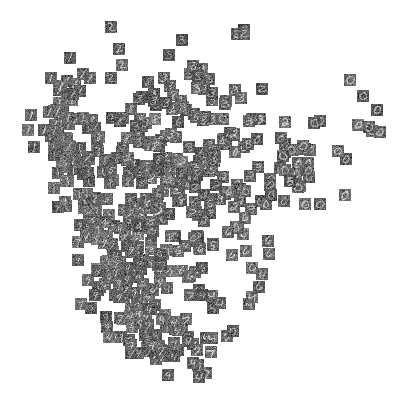

In [15]:
#traditional PCA algorithm
red = PCA(n_components=2, random_state=123) #encontrar las dos componentes principales que me ayuden a maximizar la variabilidad de los datos
Z = red.fit_transform(x_train.reshape(x_train.shape[0],-1)) #entrenar, cambiando las dimensiones de la matriz (aplanamos la imagen)
N = 500 #vamos a plotear solo 500 imagenes de nuestro espacio latente
plot_mnist_2d(Z[:N],y_train[:N],x_train[:N],img_w=28,img_h=28,zoom=0.3,cmap='gray')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28, 8) │      1,160 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28, 8) │        584 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │      1,168 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fencoded (Flatten)  │ (None, 6272)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28, 1) │        145 │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     62,730 │ fencoded[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,947 (257.61 KB)

 Trainable params: 65,947 (257.61 KB)

 Non-trainable params: 0 (0.00 B)

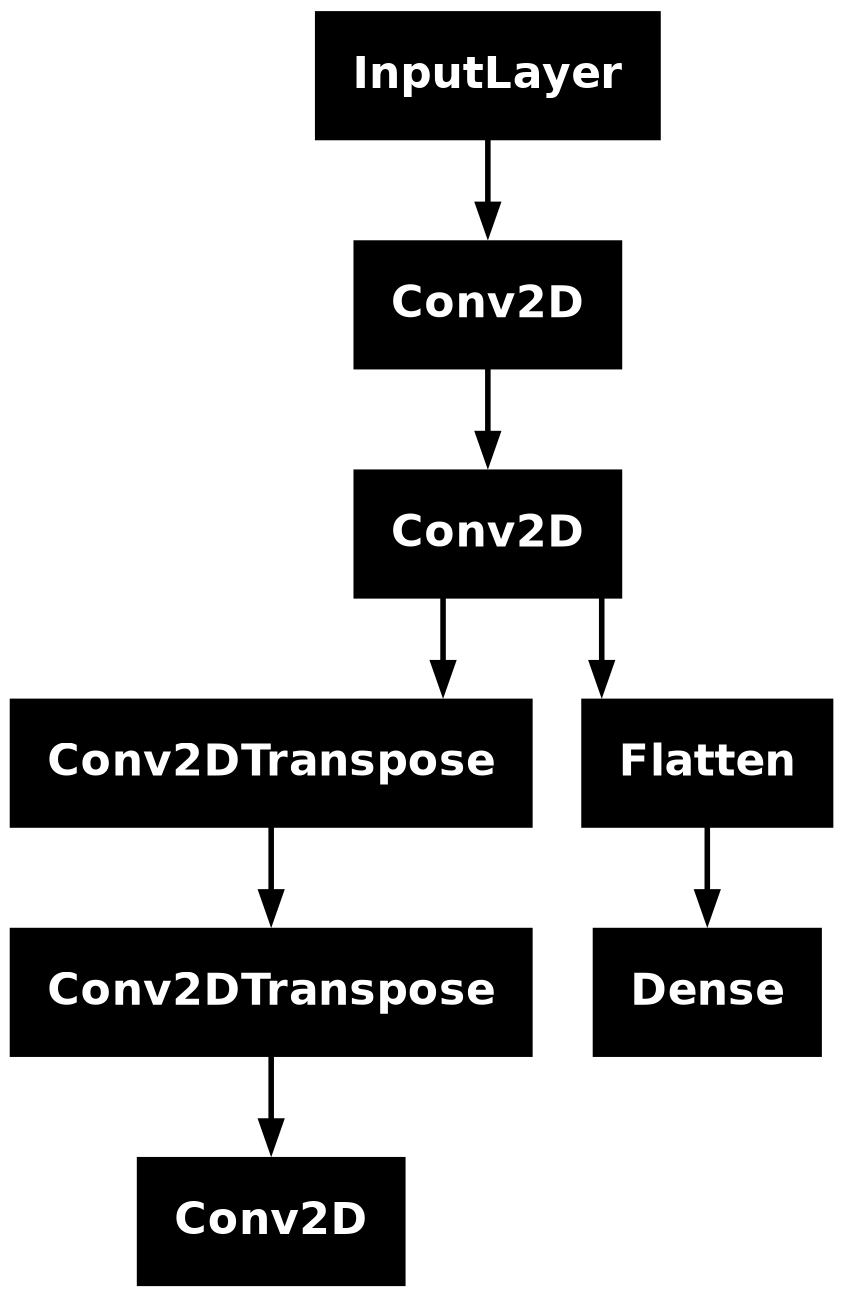

In [10]:
# Define the loss object and the optimizer
tf.keras.backend.clear_session() #limpiar la memoria

# Define the autoencoder model
input_img = Input(shape=(28, 28, 1)) #defino el tamaño de la entrada

# Encoder

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #convolucion 2D (16 filtros, 3,3 es el tamaño del kernel, a la imagen de entrada)
xe = Conv2D(8, (3, 3), activation='relu', padding='same')(x) #convolucion 2D (8 filtros, 3,3 es el tamaño del kernel,la convolución anterior)

# Decoder

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(xe) #desconvolución del espacio latente de la capa anterior (espejo)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x) #desconvolución del espacio latente de la capa enterior (espejo)
reconstructed_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) #se reconstruye la imagen con sigmoide para normalizar 

# Classification branch

x = Flatten(name='fencoded')(xe) #hacer flatten del espacio latente 
classification_output = Dense(10, activation='softmax')(x) #salida de clasificación con activacion sofmax para tener probabilidades, 10 clases

# Define the model with two outputs

autoencoder = Model(inputs=input_img, outputs=[reconstructed_img, classification_output]) #describe entrada y salida del modelo, en API Funcional de Keras

autoencoder.summary()
tf.keras.utils.plot_model(autoencoder)

In [11]:
# Custom loss function

def custom_loss(lambda_=0.5):
    def custom_loss_autoencoder(y_true, y_pred):
        reconstruction_loss = MeanSquaredError()(y_true[0], y_pred[0]) #con mse (error cuadrático medio)para minimizar la distancia 
        classification_loss = SparseCategoricalCrossentropy()(y_true[1], y_pred[1]) #pseudositancia que minimiza la distancia entre las función de densidad de probabilidad (softmax)
        return lambda_*reconstruction_loss + (1-lambda_)*classification_loss #me va a retornar la suma de ambos loss (sopésada por lambda)
    return custom_loss_autoencoder #retorna la función

# Compile the model
lam_ = 0.25 #peso del error de la reconstrucción
autoencoder.compile(optimizer=Adam(), loss=custom_loss(lambda_=lam_)) #compila el modelo con optimizador Adam y función de costo

In [17]:
# Custom training loop
batch_size = 64 #cantidad de imagenes de una iteración
epochs = 20
N = 500 #numero de imagenes que vamos a plotear
red = PCA(n_components=2, random_state=123) #definir PCA

for epoch in range(epochs): #para cada epoca... 
    print(f'Epoch {epoch+1}/{epochs}') #imprimimos la epoca en la que va
    for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=1024).batch(batch_size): #para cada lote ...
        with tf.GradientTape() as tape: #preparamos el gradiente 
            reconstruction, classification = autoencoder(x_batch, training=True) #sacamos la resconstruccion y clasificación
            loss = autoencoder.loss([x_batch, y_batch], [reconstruction, classification]) #calcular el loss del lote
            gradients = tape.gradient(loss, autoencoder.trainable_variables) #calcular el gradiente
        autoencoder.optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables)) #aplicar el gradiente

    #val
    loss_ = [] #lista de métricas
    for x_val_batch, y_val_batch in tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(buffer_size=128).batch(batch_size): #para cada lote de validación
        val_reconstruction, val_classification = autoencoder(x_val_batch, training=False) #calcular la resconstrucción y la clasificación
        loss_.append(autoencoder.loss([x_val_batch, y_val_batch], [val_reconstruction, val_classification])) #calculamos el loss y agrgar a la lista de métricas
    print(f'Loss: {loss.numpy()} Val_loss: {np.array(loss_).mean()}') #imprimimos el loss
    if (epoch+1)%5 == 0: #si la epoca es multiplo de 5...
      # Test the model
      #plot reconstruction
      #plot_mnist_autoencoder(x_val_batch,val_reconstruction) #plotea los datos de validación
      #plot encoded space
      encoder_ = tf.keras.Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('fencoded').output)
      Z = red.fit_transform(encoder_(x_val))

      #plot_mnist_2d(Z[:N],y_val[:N],x_val[:N],img_w=28,img_h=28,zoom=0.3,cmap='gray')

print('done')

Epoch 1/20
Loss: 0.01988324709236622 Val_loss: 0.23300914466381073
Epoch 2/20
Loss: 0.020526790991425514 Val_loss: 0.2325800210237503
Epoch 3/20
Loss: 0.03214520215988159 Val_loss: 0.2907080054283142
Epoch 4/20
Loss: 0.020580055192112923 Val_loss: 0.22590239346027374
Epoch 5/20
Loss: 0.020112501457333565 Val_loss: 0.2474246621131897
Epoch 6/20
Loss: 0.019738860428333282 Val_loss: 0.2560218870639801
Epoch 7/20
Loss: 0.0208699032664299 Val_loss: 0.2814077138900757
Epoch 8/20
Loss: 0.0212415661662817 Val_loss: 0.2984226942062378
Epoch 9/20
Loss: 0.020140429958701134 Val_loss: 0.29455775022506714
Epoch 10/20
Loss: 0.02032938227057457 Val_loss: 0.28096839785575867
Epoch 11/20
Loss: 0.020535307005047798 Val_loss: 0.3087008595466614
Epoch 12/20
Loss: 0.02019536681473255 Val_loss: 0.3196840286254883
Epoch 13/20
Loss: 0.02200261689722538 Val_loss: 0.30923664569854736
Epoch 14/20
Loss: 0.07146116346120834 Val_loss: 0.3073590099811554
Epoch 15/20
Loss: 0.020479248836636543 Val_loss: 0.32918563485

In [39]:
# Perform predictions with the model
reconstruccion_test, clasificacion_test = autoencoder.predict(x_test) #la prediccion del modelo en los datos de testeo

# Calculate the Mean Squared Error for the reconstruction
mse_reconstruction = MeanSquaredError()(x_test, reconstruccion_test) #calculamos el error de recostrucción de los datos de testeo

# Prepare the true and predicted labels for calculating the F1 score
# Convert labels from categorical (one-hot) format to single class format

y_test_classes = np.argmax(y_test.reshape(-1,1), axis=1) #one hot -> sparse
y_pca_pred_classes = np.argmax(clasificacion_test, axis=1) #one hot -> sparse

# Calculate the F1 score for classification
f1 = f1_score(y_test_classes, y_pca_pred_classes, average='weighted') #calculamos el f1

print(f"Mean Squared Error (Reconstruction): {mse_reconstruction}") #imprimimos el error de recosntrucción
print(f"F1 Score (Classification): {f1}") #imprimimos el f1 de clasificación 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error (Reconstruction): 0.08010926097631454
F1 Score (Classification): 0.17983254459410267


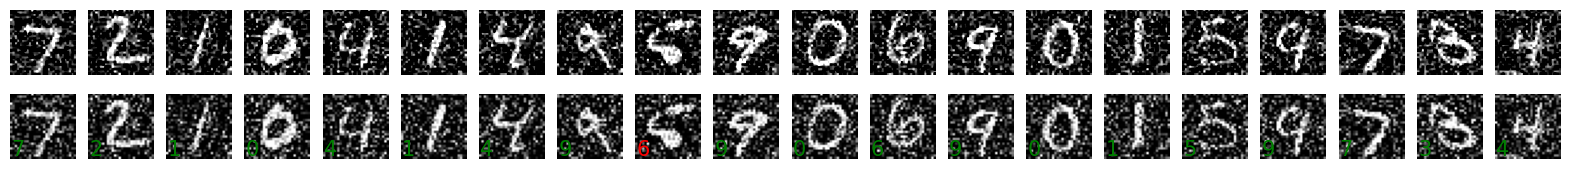

In [43]:
# Set the number of images to display
N = 20

plot_mnist_autoencoder(
    x_test[:N],  # First N original test images
    reconstruccion_test[:N],   # First N reconstructed images
    y_test[:N],  # True labels for the first N images
    clasificacion_test.argmax(axis=1)[:N]    # Predicted labels for the first N images
)